#### Read in vtu files, with the connectivities

1. Read in vtu File
2. Manage the connectivities
3. Interpolate to a unit grid
4. output

In [1]:
import vtk
import os
import numpy as np
from matplotlib import pyplot as plt
from vtk.util.numpy_support import vtk_to_numpy

#### Read in vtu file

Here we read in the pvtu file directly, this file contains the link to the vtu files, so that we import the whole domain with this step.

In [2]:
filein = "./solution/solution-00002.pvtu"
assert(os.path.isfile(filein))
reader = vtk.vtkXMLPUnstructuredGridReader()
reader.SetFileName(filein)
reader.Update()
grid = reader.GetOutput()
data_set = reader.GetOutputAsDataSet()
# reader.GetOutputDataObject()

The "grid" object from the previous block contains the mesh information, which we can print out

In [3]:
# print(grid)

#### Manage the data

##### Data concepts

Within the structure of vtk, there are grid, dataset, polydata.

In [4]:
points = grid.GetPoints()
cells = grid.GetCells()
point_data = data_set.GetPointData()

#### Get a specific array from the point data

There is a convertion utility (imported above) to convert a vtkDataArray to a numpy array.
In this case, we can see the array have the same number of field entries as the number of points.

In [5]:
data_array = vtk_to_numpy(point_data.GetArray('T'))
print("Field: T")
print("Shape of the array: ", data_array.shape)
print(data_array)

Field: T
Shape of the array:  (32256,)
[3500.      3192.051   3154.4424  ... 1156.9015   758.71094  273.     ]


#### construct a polydata

In this section, a polydata object is constructed. In the second block down below, the interfaces of this object is tried. And in the third block, it is exported to a vtp file with one of vtp's standard writer. 

To start with, We need to set the ponts and data separately. These information comes from the "points" and "point_data" output we initiated from last block. 
The tricky part is we need to add the field arrays one by one. For now, I have found how to import all the fields from the file.
There are a few points to pay attention:
* to set the first field, one need to call "SetScalars", while the "AddArray" method should be called instead for fields after that.
* One may also be confused about the "SetPolys" method. It turns out this set the cell information in the polydata. The reason for this is better visualized than explained in that one could comment out this line and visualized the two vtp file we output here and see the differences. Without the cell information, only points will be shown and the interpolation we are going to perform won't know what to do. The first file will be filled with points in that way and the second points will contain zeros in the temperature field.
* It's sort of intuitive to print out what is in the cell array. It turns out those are in the "connectivity" part of the file imported (while, as far as I understand), and they are indexes of points that make up cells.
* There is another thing called "SetVerts", which looks similar to the "SetPolys", in that they all requires the cell information. At this point, I am not sure what the differences are. Only thing I know is "SetVerts" doesn't work but "SetPolys" works.

Here is the visualized result:

![](./combined0.jpg)

In [6]:
i_poly_data = vtk.vtkPolyData()
i_poly_data.SetPoints(points)
# i_poly_data.SetVerts(cells)  # don't know what this actually does
i_poly_data.SetPolys(cells)
i_poly_data.GetPointData().SetScalars(point_data.GetArray('T'))  # put T into cell data
i_poly_data.GetPointData().AddArray(point_data.GetArray('density'))  # put T into cell data
# print(i_poly_data)  # more information

1

In [7]:
# check the interfaces of vtkPolyData
# Here we check that the same interfaces we used for the "unstructured grid" would also work for the vtkPolyData
#	get coordinates
#	get point data
temp_points = i_poly_data.GetPoints()
temp_array = vtk_to_numpy(temp_points.GetData())
print("Points from the polydata: ")
print("shape: ", temp_array.shape)
print("Data:")
print(temp_array)
temp_Ts = i_poly_data.GetPointData().GetArray('T')
temp_T_array = vtk_to_numpy(temp_Ts)
print("T from the poly data")
print("shape: ", temp_T_array.shape)
print("Data")
print(temp_T_array)

Points from the polydata: 
shape:  (32256, 3)
Data:
[[3481000.        0.        0. ]
 [3526156.2       0.        0. ]
 [3571312.5       0.        0. ]
 ...
 [3066830.  5532707.5       0. ]
 [3077776.  5552455.        0. ]
 [3088722.  5572202.        0. ]]
T from the poly data
shape:  (32256,)
Data
[3500.      3192.051   3154.4424  ... 1156.9015   758.71094  273.     ]


In [8]:
# test output directly from what's read in
fileout = "test_output.vtp"
# output
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName(fileout)
writer.SetInputData(i_poly_data)
# writer.SetFileTypeToBinary()  # try this later to see if this works
writer.Update()
writer.Write()

1

#### Interpolate to a uniform grid

To demonstrate some usage of the vtk package, the subduction fields we imported are interpolated to a uniform field in this section using vtk's built-in interpolation method.

What we need to do is to first construct a uniform mesh, then pass the mesh to a "vtkProbeFilter" object, and connect it to the polydata we constructed in the last step. Last, tell it to "Update()". This way, the interpolation will be performed. 
Another convenient feature is we could pass any object to a writer. In this case, we would export the ProbeFilter dataset directly to a vtp file.

Here is the visualized results:

There are a few things to notice.
* First, as we didn't provide any information of the cells, there are only points in the outputs.
* Second, we have entered some points that locate outside of the domain we provided (small radius). Thus, they are assigned zero values.
* Third, there is some incontinuity on the boundary of the lower mantle. For this, I am not sure what to do.


![](combine1.jpg)

In [9]:
rSize = 100
phiSize = 200
rMax = 6370e3
rMin = 2980e3
rIntr = (rMax - rMin) / rSize
phiMax = 1.064
phiMin = 0.0
phiIntr = (phiMax - phiMin) / phiSize
gridPoints = vtk.vtkPoints()
for i in range(rSize):
    for j in range(phiSize):
        val_r = rMin + i*rIntr
        val_phi = phiMin + j*phiIntr
        val_x = val_r * np.cos(val_phi)
        val_y = val_r * np.sin(val_phi)
        gridPoints.InsertNextPoint(val_x, val_y, 0)

# Create a dataset from the grid points
gridPolyData = vtk.vtkPolyData()
gridPolyData.SetPoints(gridPoints)

In [10]:
fileout = "uniform_grid_r%d_phi%d.vtp" % (rSize, phiSize)

# Perform the interpolation
print("Perform interpolation onto the new grid")
probeFilter = vtk.vtkProbeFilter()
probeFilter.SetSourceData(i_poly_data)  # use the polydata
probeFilter.SetInputData(gridPolyData) # Interpolate 'Source' at these points
probeFilter.Update()

# output
writer = vtk.vtkXMLPolyDataWriter()
writer.SetFileName(fileout)
writer.SetInputConnection(probeFilter.GetOutputPort())
writer.Update()
writer.Write()

Perform interpolation onto the new grid


1

#### Extract a temperature contour of 1200 C

Note the geometry is spherical, and the contour follows the surface of that sphere while the dip in the middle matches the slab.

Filter contour


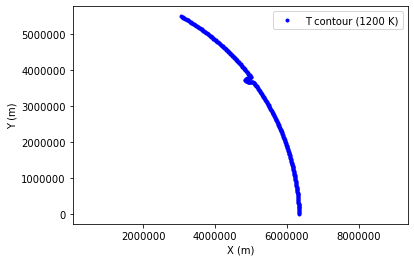

In [11]:
print("Filter contour")
contour_value = 1473.0 # 1200 C
contour_filter = vtk.vtkContourFilter()
# prepare poly data for contour, we only include field 'T' in this one
# there might be better way to do this, but this is what I could do the
# contour filter: to only import one data field.
c_poly_data = vtk.vtkPolyData()
c_vtk_point_data = i_poly_data.GetPointData()  # vtkPointData
c_poly_data.SetPoints(i_poly_data.GetPoints())  # import points and polys
c_poly_data.SetPolys(i_poly_data.GetPolys())
vtk_data_array = c_vtk_point_data.GetArray('T')
assert(vtk_data_array != None)
c_poly_data.GetPointData().SetScalars(vtk_data_array)
# draw contour 
contour_filter.SetInputData(c_poly_data)
contour_filter.Update()
contour_filter.GenerateValues(1, contour_value, contour_value)  # Extract just one contour
contour_filter.Update()
points = vtk_to_numpy(contour_filter.GetOutput().GetPoints().GetData())  # yes, we need to call 3 functions ...
# plot the contour
fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], 'b.', label="T contour (1200 K)")
ax.axis('equal')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.legend()

In [ ]:
colors = vtk.vtkNamedColors()
surfaceColor = colors.GetColor3d('Peacock')
backgroundColor = colors.GetColor3d('Silver')

# set an actor
# i_poly_data
surfaceMapper = vtk.vtkDataSetMapper()
surfaceMapper.SetInputData(i_poly_data)
surfaceMapper.ScalarVisibilityOff()

surfaceActor = vtk.vtkActor()
surfaceActor.SetMapper(surfaceMapper)
surfaceActor.GetProperty().SetDiffuseColor(surfaceColor)
surfaceActor.GetProperty().SetOpacity(.1)

renderer = vtk.vtkRenderer()
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetSize(640, 480)

renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)
renderer.SetBackground(backgroundColor)
renderer.UseHiddenLineRemovalOn()
renderer.AddActor(surfaceActor)

renderWindow.SetWindowName('TestRendering')
renderWindow.Render()
renderer.GetActiveCamera().Azimuth(30)
renderer.GetActiveCamera().Elevation(30)
renderer.GetActiveCamera().Dolly(1.25)
renderWindow.Render()

renderWindowInteractor.Start()

: 

: 